In [1]:
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
from pymoo.visualization.scatter import Scatter
from pymoo.core.algorithm import Algorithm
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time
import math

In [2]:
class MOO_ZDT1(Problem):
    def __init__(self, n_var=30):
        super().__init__(n_var=n_var,  # Definir el número de variables
                         n_obj=2,     # Dos objetivos
                         xl=0.0,      # Límite inferior de las variables
                         xu=1.0)      # Límite superior de las variables

    def _evaluate(self, x, out, *args, **kwargs):
        # Calcular el primer objetivo (f1) que es simplemente la primera variable
        f1 = x[:, 0]
        
        # Calcular la función g(x), que depende de todas las variables excepto la primera
        g = 1 + 9 * np.sum(x[:, 1:], axis=1) / (self.n_var - 1)
        
        # Calcular el segundo objetivo (f2)
        f2 = (1 - np.sqrt(f1 / g))
        
        # Asignamos los valores de los objetivos a 'F'
        out["F"] = np.column_stack([f1, f2])

## **Original solution and custom solution**

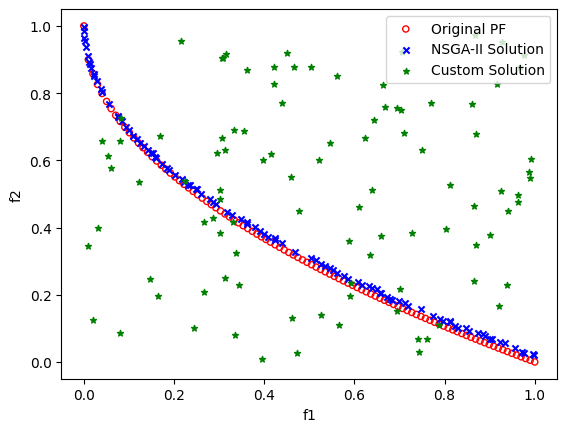

In [3]:
def plot_zdt1(solution: np.ndarray, with_nsga2: bool = True) -> None:
    # Frente de Pareto original
    problem = get_problem("zdt1")
    pareto_front = problem.pareto_front()

    if with_nsga2: # Frente de Pareto de NSGA-II
        problem = MOO_ZDT1()
        algorithm = NSGA2(pop_size=100)
        result = minimize(problem, algorithm, termination=('n_gen', 100), verbose=False)

    fig, ax = plt.subplots()

    ax.scatter(pareto_front[:, 0], pareto_front[:, 1], color='red', facecolor='none', label="Original PF", marker='o', s=20)
    if with_nsga2:
        ax.scatter(result.F[:, 0], result.F[:, 1], color='blue', label='NSGA-II Solution', marker='x', s=20)
    ax.scatter(solution[:, 0], solution[:, 1], color='green', label='Custom Solution', marker='*', s=20)

    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    ax.legend(loc='upper right')

    plt.show()

# ------------------------------
random_solution = np.random.rand(100, 2)
plot_zdt1(random_solution, with_nsga2=True)

---

## **Class implementation**

In [4]:
import math
def fitness_zdt3(individual: np.ndarray) -> np.ndarray:
    # f1 que es simplemente la primera variable
    f1 = np.array(individual[0])
    
    # g(x), que depende de todas las variables excepto la primera
    g = 1 + (9 / (len(individual) - 1)) * np.sum(individual[1:]) 
    
    # Calcular f2
    f2 = 1 - np.sqrt(f1 / g )-(f1/g)*math.sin(10*math.pi*f1)
    
    return np.array([f1, f2])
def fitness_zdt1(individual: np.ndarray) -> np.ndarray:
    # f1 que es simplemente la primera variable
    f1 = individual[0]
    
    # g(x), que depende de todas las variables excepto la primera
    g = 1 + 9*np.sum(individual[1:]) / (len(individual)-1) 
    
    # Calcular f2
    f2 = 1 - np.sqrt(f1 / g )
    
    return np.array([f1, f2])


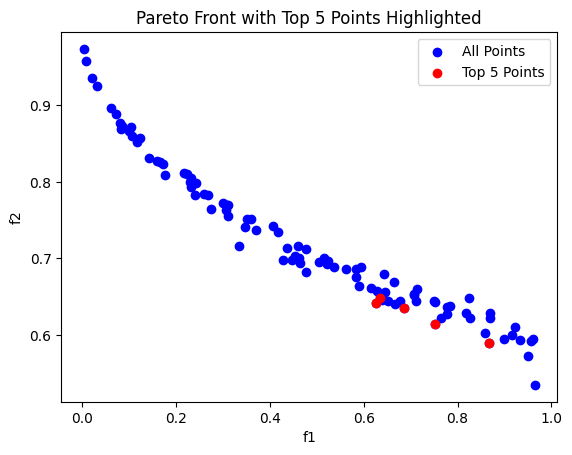

In [5]:
random_individuals = np.random.rand(100, 30)
reverse_sort = True
fitness_function = fitness_zdt1
top_n = 5

def dominates(ind1: np.ndarray, ind2: np.ndarray) -> bool:
    """Check if ind1 dominates ind2."""
    return all(i <= j for i, j in zip(ind1, ind2)) and any(i < j for i, j in zip(ind1, ind2))

fitness_list = np.array([fitness_function(ind) for ind in random_individuals])
num_individuals = len(fitness_list)
dominance_count = np.zeros(num_individuals, dtype=int)

for i in range(num_individuals):
    for j in range(num_individuals):
        if dominates(fitness_list[i], fitness_list[j]):
            dominance_count[i] += 1

sorted_indices = np.argsort(-dominance_count) if reverse_sort else np.argsort(dominance_count)
sorted_population = fitness_list[sorted_indices]

# Plotting
plt.scatter(fitness_list[:, 0], fitness_list[:, 1], color='blue', label='All Points')
plt.scatter(sorted_population[:top_n, 0], sorted_population[:top_n, 1], color='red', label=f'Top {top_n} Points')
plt.xlabel('f1')
plt.ylabel('f2')
plt.title(f'Pareto Front with Top {top_n} Points Highlighted')
plt.legend()
plt.show()

In [103]:
class MOO_Genetic_ZDT1():
    def __init__(self, population_size: int, num_variables: int = 30):
        self.num_variables = num_variables
        self.population = np.random.rand(population_size, num_variables)
        self.fitnesses = np.zeros(population_size)

        # -----------------------------------
        """Sort population by dominance and crowding distance."""

    def sort_pop(self, fitness_function, reverse_sort: bool=True, weight_hv=1.0, weight_fs=1.0, weight_cd=1.0) -> None:
        # Compute objectives for all individuals
        objectives = np.array([fitness_function(ind) for ind in self.population])
        num_individuals = len(objectives)

        # Rank individuals based on dominance
        ranks = np.zeros(num_individuals)
        for i in range(num_individuals):
            for j in range(num_individuals):
                if i != j:
                    if (objectives[i][0] >= objectives[j][0] and objectives[i][1] > objectives[j][1]) or \
                    (objectives[i][0] > objectives[j][0] and objectives[i][1] >= objectives[j][1]):
                        ranks[i] += 1

        # Calculate crowding distance
        crowding_distances = np.zeros(num_individuals)
        for m in range(objectives.shape[1]):
            sorted_indices = np.argsort(objectives[:, m])
            crowding_distances[sorted_indices[0]] = crowding_distances[sorted_indices[-1]] = np.inf
            for k in range(1, num_individuals - 1):
                crowding_distances[sorted_indices[k]] += (objectives[sorted_indices[k + 1], m] - objectives[sorted_indices[k - 1], m]) / (objectives[sorted_indices[-1], m] - objectives[sorted_indices[0], m])

        # Calculate hypervolume contribution
        reference_point = np.max(objectives, axis=0) * 1.1  # Reference point for hypervolume calculation
        hypervolume_contributions = np.zeros(num_individuals)
        for i in range(num_individuals):
            temp_objectives = np.delete(objectives, i, axis=0)
            hypervolume_contributions[i] = self.calculate_hypervolume(temp_objectives, reference_point) - self.calculate_hypervolume(objectives, reference_point)

        # Fitness sharing
        sigma_share = 0.5  # Sharing parameter
        alpha = 1  # Sharing exponent
        shared_fitnesses = np.zeros(num_individuals)
        for i in range(num_individuals):
            sh_sum = 0
            for j in range(num_individuals):
                dist = np.linalg.norm(objectives[i] - objectives[j])
                if dist < sigma_share:
                    sh_sum += 1 - (dist / sigma_share) ** alpha
            shared_fitnesses[i] = 1 / sh_sum if sh_sum > 0 else 1

        # Normalize crowding distances and hypervolume contributions for balancing
        max_crowding = np.max(crowding_distances)
        max_hypervolume = np.max(hypervolume_contributions)
        crowding_distances /= max_crowding
        hypervolume_contributions /= max_hypervolume

        # Combine ranks, crowding distances, hypervolume contributions, and shared fitnesses
        combined = list(zip(self.population, ranks, crowding_distances, hypervolume_contributions, shared_fitnesses))

        # Sort based on a weighted combination of the factors
        combined.sort(key=lambda x: (x[1], -x[2] * weight_cd, -x[3] * weight_hv, -x[4] * weight_fs))

        # Update population and fitnesses
        self.population = np.array([x[0] for x in combined])
        self.fitnesses = np.array([fitness_function(ind) for ind in self.population])
        self.dominances = np.array([x[1] for x in combined])



    def calculate_hypervolume(self, objectives, reference_point):
        """Calculate the hypervolume given a set of objectives and a reference point."""
        # Sort the objectives by the first objective (f1)
        sorted_objectives = objectives[np.argsort(objectives[:, 0])]
        
        # Initialize hypervolume
        hypervolume = 0.0
        
        # Iterate through the sorted objectives
        for i in range(len(sorted_objectives)):
            if i == 0:
                width = reference_point[0] - sorted_objectives[i][0]
            else:
                width = sorted_objectives[i - 1][0] - sorted_objectives[i][0]
            
            height = reference_point[1] - sorted_objectives[i][1]
            hypervolume += width * height
        
        return hypervolume

    def select(self, T: int) -> np.ndarray:
        """Return a copy of an individual by binary tournament selection."""

        # Randomly select two individuals
        i, j = random.sample(range(len(self.population)), 2)

        # Compare their dominance count
        if self.dominances[i] < self.dominances[j]:
            return self.population[i]
        elif self.dominances[i] > self.dominances[j]:
            return self.population[j]
        else:
            # If dominance count is the same, compare their fitness
            if np.sum(self.fitnesses[i]) < np.sum(self.fitnesses[j]):
                return self.population[i]
            else:
                return self.population[j]
    
    def crossover(self, parent1: np.ndarray, parent2: np.ndarray, pcross: float) -> tuple[np.ndarray, np.ndarray]:
        """Simulated Binary Crossover (SBX)"""
        
        child1 = parent1.copy()
        child2 = parent2.copy()

        if random.random() < pcross:
            eta = 4  # Distribution index for SBX
            for i in range(len(parent1)):
                u = random.random()
                if u <= 0.5:
                    beta = (2 * u) ** (1 / (eta + 1))
                else:
                    beta = (1 / (2 * (1 - u))) ** (1 / (eta + 1))
                
                child1[i] = 0.5 * ((1 + beta) * parent1[i] + (1 - beta) * parent2[i])
                child2[i] = 0.5 * ((1 - beta) * parent1[i] + (1 + beta) * parent2[i])
            
            # Ensure children are within bounds [0, 1]
            child1 = np.clip(child1, 0.0, 1.0)
            child2 = np.clip(child2, 0.0, 1.0)

        return child1, child2
    
    def get_pareto(self):
        # Number of individuals
        n = self.fitnesses.shape[0]
        
        # List to store the indices of the individuals in the Pareto front
        pareto_front = []
        
        # Iterate over each individual
        for i in range(n):
            is_dominated = False
            # Compare with every other individual
            for j in range(n):
                if (self.fitnesses[j, 0] <= self.fitnesses[i, 0]) and (self.fitnesses[j, 1] <= self.fitnesses[i, 1]) and not np.array_equal(self.fitnesses[i], self.fitnesses[j]):
                    is_dominated = True
                    break
            if not is_dominated:
                pareto_front.append(i)
        
        return self.fitnesses[pareto_front]

    def mutate(self, individual: np.ndarray, pmut: float) -> np.ndarray:
        """Polynomial mutation. Return mutated individual"""
        eta_m = 20  # Distribution index for polynomial mutation

        for i in range(len(individual)):
            if random.random() < pmut:
                u = random.random()
                if u < 0.5:
                    delta = (2 * u) ** (1 / (eta_m + 1)) - 1
                else:
                    delta = 1 - (2 * (1 - u)) ** (1 / (eta_m + 1))

                individual[i] += delta
                # Ensure the mutated individual is within bounds [0, 1]
                individual[i] = np.clip(individual[i], 0.0, 1.0)

        return individual

    def evolve(self, fitness_function, pmut=0.0, pcross=0.0, ngen=100, T=2, trace=50, reverse_sort=True, elitism=False) -> None:
        """Evolution procedure. Initial population already created"""

        for i in range(ngen):
            new_pop = []
            self.sort_pop(fitness_function, reverse_sort, weight_hv=1.5, weight_fs=4.0, weight_cd=0.5)

            if elitism:
                # Preserve the best individual(s)
                elite_size = 1  # Number of elite individuals to preserve
                elites = self.population[:elite_size]
                new_pop.extend(elites)

            while len(new_pop) < self.population.shape[0]: 
                parent1 = self.select(T)
                parent2 = self.select(T)
                child1, child2 = self.crossover(parent1, parent2, pcross)
                mutated1 = self.mutate(child1, pmut)
                mutated2 = self.mutate(child2, pmut)
                new_pop.append(mutated1)
                new_pop.append(mutated2)

            new_pop = np.array(new_pop)
            if new_pop.shape[0] > self.population.shape[0]:
                new_pop = new_pop[:self.population.shape[0]]

            self.population = copy.deepcopy(new_pop)

            if i % trace == 0 or i == ngen-1:  # en la última generación se ordena
                self.sort_pop(fitness_function, reverse_sort, weight_hv=1.5, weight_fs=4.0, weight_cd=0.5)
                print(f"Nº gen: {i}, Best fitness: {self.fitnesses[0]}")

C:\Users\afrai\AppData\Local\Temp\ipykernel_15076\1227822906.py:54: RuntimeWarning: invalid value encountered in divide
  crowding_distances /= max_crowding


Nº gen: 0, Best fitness: [0.78136029 0.60532508]
Nº gen: 20, Best fitness: [0. 1.]
Nº gen: 40, Best fitness: [0. 1.]
Nº gen: 60, Best fitness: [0. 1.]
Nº gen: 80, Best fitness: [0. 1.]
Nº gen: 99, Best fitness: [0. 1.]
*******Tiempo evolución: 0 minutos y 4.35 segundos*******


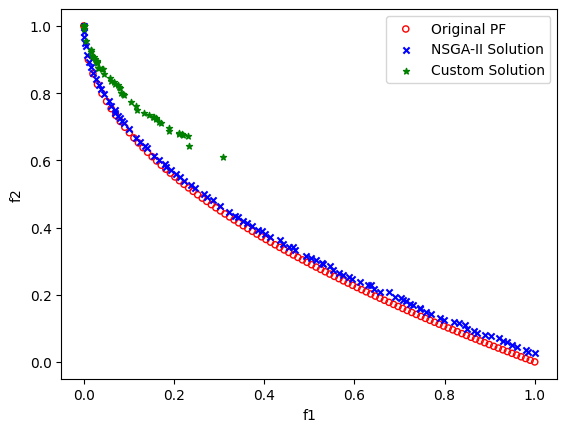

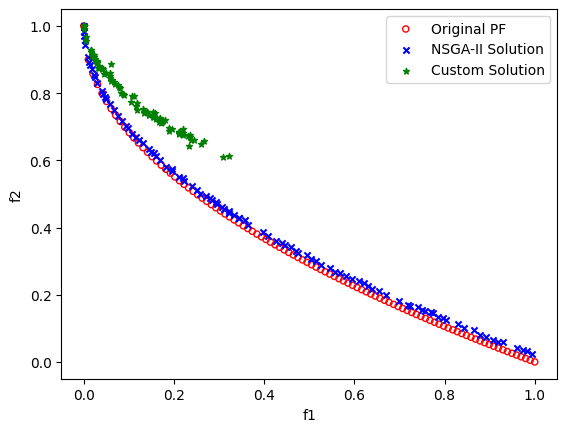

In [104]:
genetic_algorithm = MOO_Genetic_ZDT1(population_size=100)

start = time.time()
genetic_algorithm.evolve(fitness_function=fitness_zdt1, pmut=0.3, pcross=0.8, ngen=100, T=6, trace=20, reverse_sort=True,elitism=True)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")
p=genetic_algorithm.get_pareto()
plot_zdt1(p, with_nsga2=True)
p=genetic_algorithm.fitnesses
plot_zdt1(p, with_nsga2=True)

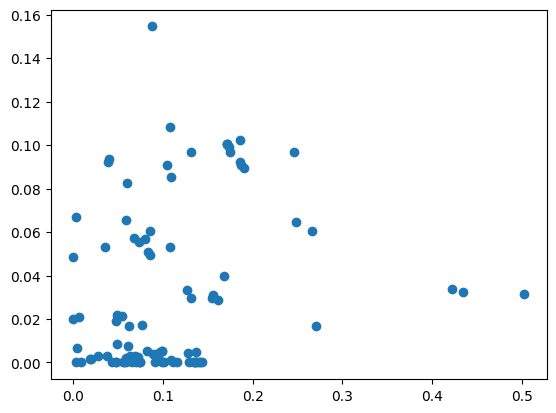

In [81]:
plt.plot(genetic_algorithm.population[:, 0], genetic_algorithm.population[:, 1], 'o')

INSTANCIACION:


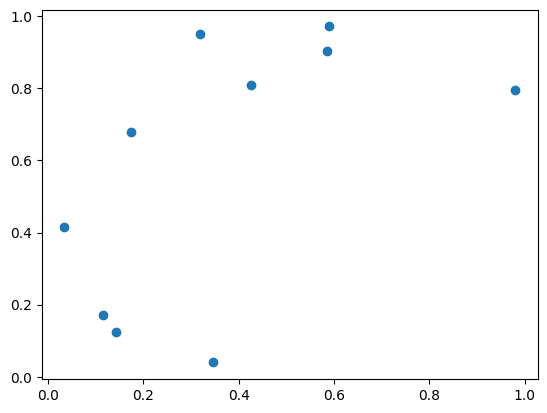

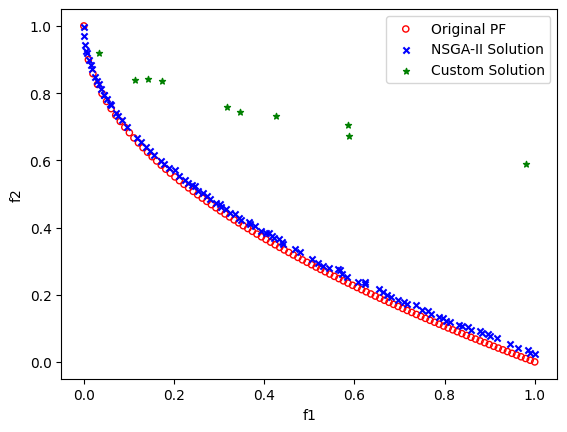

In [43]:
genetic_algorithm = MOO_Genetic_ZDT1(population_size=10)
genetic_algorithm.sort_pop(fitness_function=fitness_zdt1, reverse_sort=True)

print("INSTANCIACION:")
plt.plot(genetic_algorithm.population[:, 0], genetic_algorithm.population[:, 1], 'o')
p_0=genetic_algorithm.fitnesses
plot_zdt1(p_0, with_nsga2=True)

Nº gen: 0, Best fitness: [0.3461759  0.74320203]
GENERACION 1:


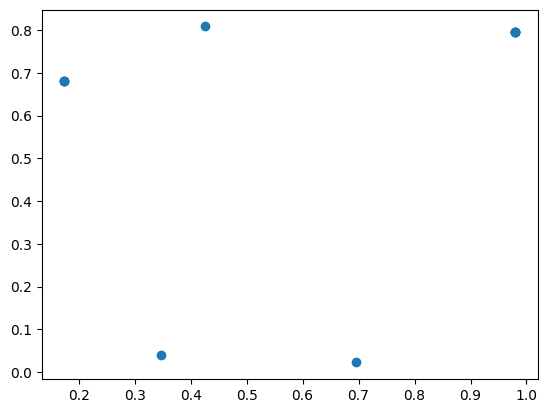

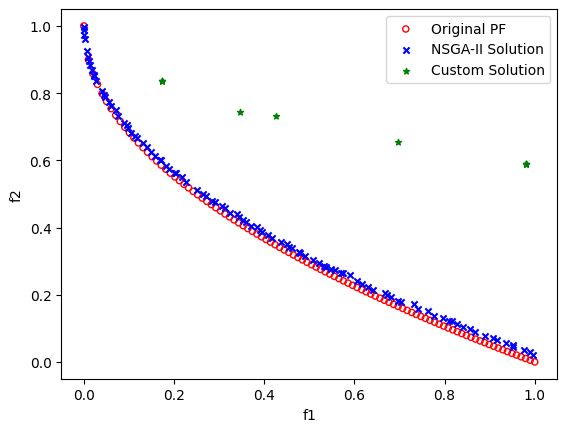

In [44]:
genetic_algorithm.evolve(fitness_function=fitness_zdt1, pmut=0.1, pcross=0.4, ngen=1, T=4, trace=20, reverse_sort=True,elitism=False)

print("GENERACION 1:")
plt.plot(genetic_algorithm.population[:, 0], genetic_algorithm.population[:, 1], 'o')
p_1=genetic_algorithm.fitnesses
plot_zdt1(p_1, with_nsga2=True)

In [45]:
print(p_0)
print(p_1)

[[0.97980352 0.58909142]
 [0.42608999 0.73311509]
 [0.17422559 0.83692134]
 [0.58524169 0.70430921]
 [0.3179898  0.75782672]
 [0.3461759  0.74320203]
 [0.58910878 0.67369805]
 [0.11452887 0.83929749]
 [0.03423126 0.92075231]
 [0.14336691 0.84096986]]
[[0.3461759  0.74320203]
 [0.97980352 0.58909142]
 [0.97980352 0.58909142]
 [0.97980352 0.58909142]
 [0.42608999 0.73311509]
 [0.17422559 0.83692134]
 [0.17422559 0.83692134]
 [0.17422559 0.83692134]
 [0.97980352 0.58909142]
 [0.69615667 0.65509281]]


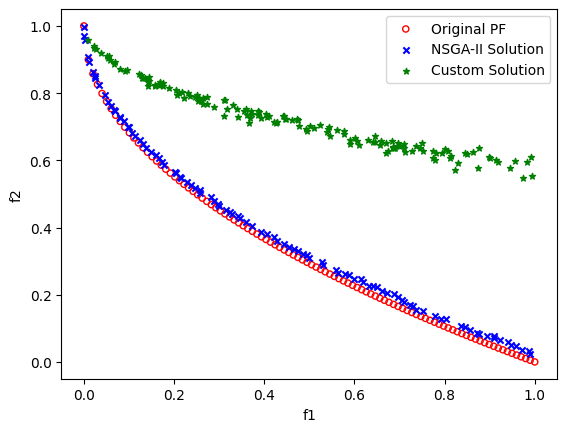

In [31]:
plot_zdt1(genetic_algorithm.fitnesses.clip(0.0,1.0), with_nsga2=True)

In [57]:
print(type(final_objectives))

<class 'list'>


In [149]:
unique_rows, counts = np.unique(genetic_algorithm.population, axis=0, return_counts=True)
    
    # Count how many rows have more than one occurrence
repeated_count = np.sum(counts > 1)
repeated_count

np.int64(11)

In [150]:
len(np.unique(genetic_algorithm.population,axis=0)),len(np.unique(genetic_algorithm.fitnesses,axis=0))

(84, 61)

In [29]:
import imageio
import os

# Folder containing the images
image_folder = 'gens'
# Output GIF file
output_gif = 'evolution.gif'

# Get all image files in the folder
images = []
for file_name in sorted(os.listdir(image_folder)):
    if file_name.endswith('.png'):
        file_path = os.path.join(image_folder, file_name)
        images.append(imageio.imread(file_path))

# Create and save the GIF
imageio.mimsave(output_gif, images, duration=250, loop=1)

/tmp/ipykernel_127978/1165862860.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


---

In [135]:
import numpy as np

def zdt1_objectives(individual):
    """
    Compute the objectives f1 and f2 for an individual based on ZDT1.

    Parameters:
    - individual (np.ndarray): Decision variables.

    Returns:
    - (f1, f2): The two objective values.
    """
    n = len(individual)
    
    # Objective 1
    f1 = individual[0]
    
    # Auxiliary function g(x)
    g = 1 + (9 / (n - 1)) * np.sum(individual[1:])
    
    # Objective 2
    f2 = (1 - np.sqrt(f1 / g))
    
    return f1, f2


In [136]:
def dominates(ind1, ind2):
    return all(i <= j for i, j in zip(ind1, ind2)) and any(i < j for i, j in zip(ind1, ind2))

In [137]:
def pareto_ranking(population):
    # Compute objectives for all individuals
    objectives = [zdt1_objectives(ind) for ind in population]
    num_individuals = len(objectives)
    
    # Initialize dominance counts and dominance sets
    domination_count = np.zeros(num_individuals, dtype=int)
    dominated_sets = [[] for _ in range(num_individuals)]
    fronts = [[]]
    
    # Determine dominance relationships
    for i in range(num_individuals):
        for j in range(num_individuals):
            if dominates(objectives[i], objectives[j]):
                dominated_sets[i].append(j)
            elif dominates(objectives[j], objectives[i]):
                domination_count[i] += 1
                
        # If no one dominates individual i, it belongs to the first front
        if domination_count[i] == 0:
            fronts[0].append(i)
    
    # Assign subsequent fronts
    current_front = 0
    while fronts[current_front]:
        next_front = []
        for i in fronts[current_front]:
            for j in dominated_sets[i]:
                domination_count[j] -= 1
                if domination_count[j] == 0:
                    next_front.append(j)
        fronts.append(next_front)
        current_front += 1
    
    # Remove empty last front
    if not fronts[-1]:
        fronts.pop()
    
    # Assign ranks
    ranks = np.zeros(num_individuals, dtype=int)
    for rank, front in enumerate(fronts):
        for i in front:
            ranks[i] = rank + 1  # Rank starts at 1
    
    return ranks, fronts

In [140]:
# Example population of individuals (random decision variables)
population = [np.random.rand(10) for _ in range(100)]

# Pareto ranking
ranks, fronts = pareto_ranking(population)

# Display Pareto fronts
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {[population[idx] for idx in front]}")
    break

Front 1: [array([0.9506894 , 0.01815956, 0.36255133, 0.43362609, 0.14041377,
       0.45002929, 0.21266176, 0.15351261, 0.09464042, 0.57777435]), array([0.508336  , 0.8992435 , 0.10287011, 0.79954388, 0.14007444,
       0.08779709, 0.05449411, 0.18039428, 0.18714586, 0.07420293]), array([0.63249023, 0.32809799, 0.80738363, 0.01713714, 0.1808669 ,
       0.08066114, 0.2747859 , 0.17157677, 0.04720218, 0.42598684]), array([0.02060408, 0.17664709, 0.22232715, 0.59644722, 0.02500278,
       0.06668406, 0.04524115, 0.19688777, 0.16140691, 0.03582867]), array([0.00307289, 0.8043131 , 0.64577893, 0.42444126, 0.29909891,
       0.60867529, 0.16819469, 0.96836796, 0.78660396, 0.57495818])]


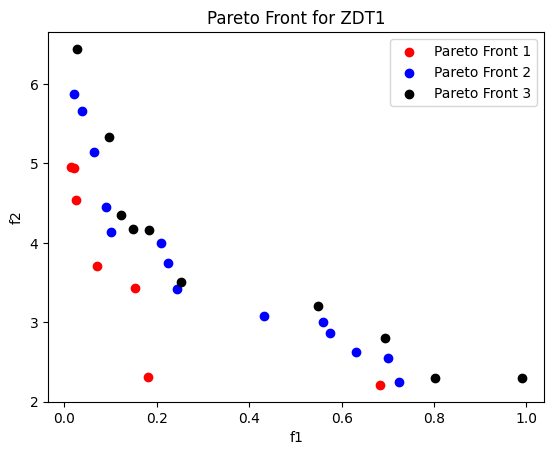

In [120]:
import matplotlib.pyplot as plt

# Extract objectives for the first front
front1_indices = fronts[0]
front1_objectives = [zdt1_objectives(population[i]) for i in front1_indices]
f1_values, f2_values = zip(*front1_objectives)
plt.scatter(f1_values, f2_values, label="Pareto Front 1", color="red")

front1_indices = fronts[1]
front1_objectives = [zdt1_objectives(population[i]) for i in front1_indices]
f1_values, f2_values = zip(*front1_objectives)
plt.scatter(f1_values, f2_values, label="Pareto Front 2", color="blue")

front1_indices = fronts[2]
front1_objectives = [zdt1_objectives(population[i]) for i in front1_indices]
f1_values, f2_values = zip(*front1_objectives)
plt.scatter(f1_values, f2_values, label="Pareto Front 3", color="black")

plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Pareto Front for ZDT1")
plt.legend()
plt.show()